[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/YichenShen0103/CUMCM-25C/blob/main/problem2.ipynb)

In [1]:
!pip install lifelines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import warnings
from typing import Dict
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
# read in data
url = 'https://raw.githubusercontent.com/YichenShen0103/CUMCM-25C/main/data/data.xlsx'
data = pd.read_excel(url, sheet_name=0)
data.dropna(subset=["检测孕周", "GC含量", "孕妇BMI", "Y染色体浓度"], inplace=True)
data

,序号,孕妇代码,年龄,身高,体重,末次月经,IVF妊娠,检测日期,检测抽血次数,检测孕周,...,Y染色体浓度,X染色体浓度,13号染色体的GC含量,18号染色体的GC含量,21号染色体的GC含量,被过滤掉读段数的比例,染色体的非整倍体,怀孕次数,生产次数,胎儿是否健康
0,1,A001,31,160.0,72.00,2023-02-01 00:00:00,自然受孕,20230429,1,11w+6,...,0.025936,0.038061,0.377069,0.389803,0.399399,0.027484,NaN,1,0,是
1,2,A001,31,160.0,73.00,2023-02-01 00:00:00,自然受孕,20230531,2,15w+6,...,0.034887,0.059572,0.371542,0.384771,0.391706,0.019617,NaN,1,0,是
2,3,A001,31,160.0,73.00,2023-02-01 00:00:00,自然受孕,20230625,3,20w+1,...,0.066171,0.075995,0.377449,0.390582,0.399480,0.022312,NaN,1,0,是
3,4,A001,31,160.0,74.00,2023-02-01 00:00:00,自然受孕,20230716,4,22w+6,...,0.061192,0.052305,0.375613,0.389251,0.397212,0.023280,NaN,1,0,是
4,5,A002,32,149.0,74.00,2023-11-09 00:00:00,自然受孕,20240219,1,13w+6,...,0.059230,0.059708,0.380260,0.393618,0.404868,0.024212,NaN,2,1,否
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,1078,A266,30,159.0,83.35,2022-12-29,自然受孕,2023-05-02 00:00:00,4,17w+5,...,0.099052,0.056686,0.376861,0.389914,0.397090,0.017951,T18,1,0,是
1078,1079,A267,28,155.0,73.76,2023-02-25,自然受孕,2023-05-17 00:00:00,1,11w+4,...,0.098706,0.023663,0.377597,0.387901,0.404293,0.022549,T21,1,0,是
1079,1080,A267,28,155.0,74.06,2023-02-25,自然受孕,2023-05-24 00:00:00,2,12w+4,...,0.102088,0.080264,0.379041,0.391748,0.400433,0.021330,NaN,1,0,是
1080,1081,A267,28,155.0,74.74,2023-02-25,自然受孕,2023-05-31 00:00:00,3,13w+4,...,0.109855,0.074050,0.379107,0.388544,0.401030,0.022013,NaN,1,0,是


(74, 4)
57


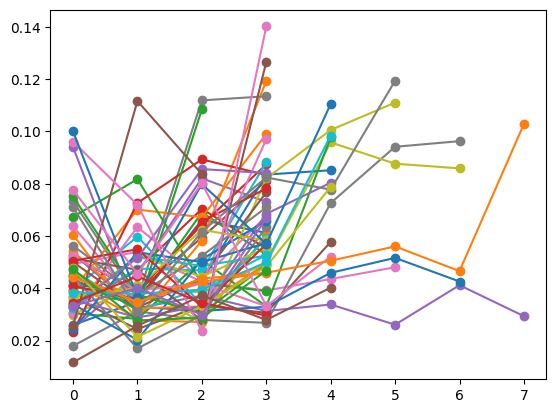

In [3]:
data0 = data.groupby("孕妇代码", as_index=False)["Y染色体浓度"].agg(
    list_values=list, 
    min_value="min", 
    max_value="max"
)
data0 = data0[(data0["min_value"] < 0.04) & (data0["max_value"] > 0.04)]
print(data0.shape)

def is_non_decreasing(lst):
    return all(x <= y for x, y in zip(lst, lst[1:]))

count = 0
for i in data0.index:
    if is_non_decreasing(data0.loc[i, "list_values"]) == False:
        plt.plot(data0.loc[i, "list_values"], marker='o')
        count += 1

print(count)
plt.show()



(1082, 32)


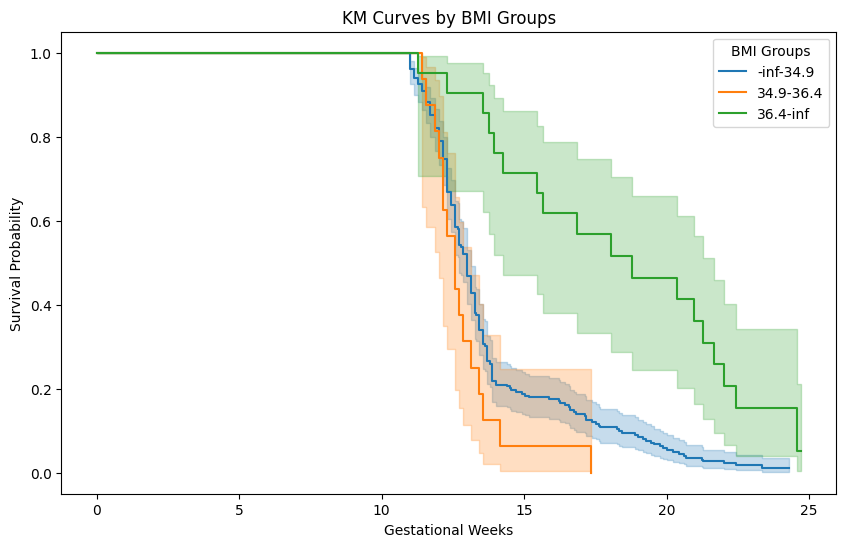

Optimal BMI Cut Points: [34.9, 36.4]
Cutpoints p-values: [0.0, 0.084]
Cutpoints with Measurement Error: [36.4]
Cutpoints p-values with Measurement Error: [0.0]
Optimal NIPT Times (weeks):
  -inf-34.9  -> 18.3
  34.9-36.4  -> 14.2
  36.4-inf   -> 24.6
NIPT Times with Measurement Error (weeks):
  -inf-36.4  -> 18.0
  36.4-inf   -> 24.4


In [4]:
def compute_event_time(df, threshold=0.04):
    results = []
    for mid, sub in df.groupby("mother_id"):
        sub = sub.sort_values("gestational_weeks")
        bmis = sub["bmi"].values
        times = sub["gestational_weeks"].values
        y_concs = sub["y_concentration"].values
        event_time = None
        event_occurred = 0
        for i in range(1, len(y_concs)):
            if y_concs[i - 1] < threshold and y_concs[i] >= threshold:
                # 线性插值计算事件时间
                t1, t2 = times[i - 1], times[i]
                y1, y2 = y_concs[i - 1], y_concs[i]
                event_time = t1 + (threshold - y1) * (t2 - t1) / (y2 - y1)
                event_occurred = 1
                break
        if event_time is None:
            if np.any(y_concs >= threshold):
                event_time = times[np.argmax(y_concs >= threshold)]
                event_occurred = 1
            else:
                event_time = times[-1]
                event_occurred = 0
        # results.append((mid, event_time, event_occurred, bmis))
        event_bmi = sub["bmi"].values[
            np.searchsorted(times, event_time, side="right") - 1
        ]
        results.append((mid, event_time, event_occurred, event_bmi))
    return pd.DataFrame(results, columns=["mother_id", "time", "event", "bmi"])


def find_best_cut(data, min_size=20, alpha=0.05):
    sorted_bmi = np.sort(data["bmi"].unique())
    best_cut = None
    best_p = 1.0
    best_stat = -np.inf

    for cut in sorted_bmi[1:-1]:
        group1 = data[data["bmi"] <= cut]
        group2 = data[data["bmi"] > cut]

        if len(group1) < min_size or len(group2) < min_size:
            continue

        result = logrank_test(
            group1["time"],
            group2["time"],
            event_observed_A=group1["event"],
            event_observed_B=group2["event"],
        )
        if result.test_statistic > best_stat:
            best_stat = result.test_statistic
            best_cut = cut
            best_p = result.p_value

    if best_p < alpha:
        return best_cut, best_stat, best_p
    else:
        return None, None, None


def recursive_partition_with_p(df, max_groups=5, min_size=20, alpha=0.05):
    cuts = []
    cut_pvalues = []

    def split(data):
        if len(cuts) >= max_groups - 1:
            return
        cut, stat, p = find_best_cut(data, min_size, alpha)
        if cut is not None:
            cuts.append(cut)
            cut_pvalues.append(p)  # 保存对应 p 值
            split(data[data["bmi"] <= cut])
            split(data[data["bmi"] > cut])

    split(df)
    cuts = sorted(cuts)
    cut_pvalues_sorted = [p for _, p in sorted(zip(cuts, cut_pvalues))]
    bins = [-np.inf] + cuts + [np.inf]
    labels = [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(len(bins) - 1)]
    df["bmi_group"] = pd.cut(df["bmi"], bins=bins, labels=labels)
    return df, cuts, cut_pvalues_sorted

def best_nipt_times(data):
    kmf = KaplanMeierFitter()
    best_times = {}
    for group, sub in data.groupby("bmi_group"):
        sub = sub.dropna()
        if len(sub) < 10:
            continue
        kmf.fit(sub["time"], event_observed=sub["event"])
        surv = kmf.survival_function_
        crossing = surv[surv["KM_estimate"] <= 0.1]
        if not crossing.empty:
            best_times[group] = crossing.index[0]
        else:
            best_times[group] = np.nan
    return best_times


def add_measurement_error(df, error_std=0.005):
    np.random.seed(42)
    df_err = df.copy()
    df_err["y_concentration"] += np.random.normal(0, error_std, size=len(df_err))
    df_err["y_concentration"] = df_err["y_concentration"].clip(0, 1)
    return df_err

df = pd.read_excel(url, sheet_name=0)
weeks_days = df["检测孕周"].str.split(r"[wW]", expand=True)
df["孕天"] = (
    weeks_days[0].astype(int) * 7
    + weeks_days[1].fillna("0").replace("", "0").astype(int)
)
# df["检测日期"] = pd.to_datetime(df["检测日期"], format="%Y%m%d")
# df["末次月经"] = pd.to_datetime(df["末次月经"], format="%Y-%m-%d")
# df["delta_days"] = (df["检测日期"] - df["末次月经"]).dt.days - df["孕天"]
# df = df[abs(df["delta_days"]) <= 3]
# df.drop(columns=["delta_days", "生产次数"], inplace=True)
df['孕天'] = df['孕天'].astype(np.float64) / 7.0  # convert to weeks

col_map_cn = {
    "孕妇代码": "mother_id",
    "检测孕周": "gestational_age",
    "孕妇BMI": "bmi",
    "年龄": "age",
    "Y染色体浓度": "y_concentration",
    "检测日期": "test_date",
    "末次月经": "last_menstrual_period",
    "身高": "height",
    "体重": "weight",
    "在参考基因组上比对的比例": "mapping_ratio",
    "GC含量": "GC",
    "孕天": "gestational_weeks",
}
df = df.rename(columns=col_map_cn)
print(df.shape)
df_event = compute_event_time(
    df[["mother_id", "gestational_weeks", "bmi", "y_concentration"]]
)
df_grouped, cuts, cut_pvalues = recursive_partition_with_p(df_event, max_groups=3, min_size=5, alpha=0.1)

kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))
for group, sub in df_grouped.groupby("bmi_group"):
    sub = sub.dropna()
    kmf.fit(sub["time"], event_observed=sub["event"], label=str(group))
    kmf.plot_survival_function()
plt.xlabel("Gestational Weeks")
plt.ylabel("Survival Probability")
plt.title("KM Curves by BMI Groups")
plt.legend(title="BMI Groups")
plt.show()

best_times = best_nipt_times(df_grouped)
df_err = add_measurement_error(df)
df_event_err = compute_event_time(
    df_err[["mother_id", "gestational_weeks", "bmi", "y_concentration"]]
)
df_grouped_err, cuts_err, cut_pvalues_err = recursive_partition_with_p(df_event_err)
best_times_err = best_nipt_times(df_grouped_err)


def fmt_list(lst, digits=1):
    return [round(float(x), digits) for x in lst]


def fmt_dict(dct, digits=1):
    return {k: round(float(v), digits) for k, v in dct.items()}


print("Optimal BMI Cut Points:", fmt_list(cuts))
print("Cutpoints p-values:", fmt_list(cut_pvalues, digits=3))
print("Cutpoints with Measurement Error:", fmt_list(cuts_err))
print("Cutpoints p-values with Measurement Error:", fmt_list(cut_pvalues_err, digits=3))

print("Optimal NIPT Times (weeks):")
for k, v in fmt_dict(best_times).items():
    print(f"  {k:10s} -> {v}")
print("NIPT Times with Measurement Error (weeks):")
for k, v in fmt_dict(best_times_err).items():
    print(f"  {k:10s} -> {v}")


In [5]:
# 分段风险惩罚函数
def _risk_penalty(t: float) -> float:
    return (t**2 - 1.0) / (624.0)  # 归一化到 [0, 1]


def risk_aware_optimal_time(
    sub: pd.DataFrame,
    alpha: float = 1.0,   # 权重：失败率（1-coverage）
    beta: float = 1.0,    # 权重：风险惩罚
    gamma: float = 0.02,  # 权重：孕周（鼓励更早）
    grid: np.ndarray | None = None,
) -> Dict:
    sub = sub.dropna()
    if len(sub) < 5:
        return {
            "t_star": np.nan,
            "S_t": np.nan,
            "coverage": np.nan,
            "objective": np.inf,
        }

    kmf_local = KaplanMeierFitter()
    kmf_local.fit(sub["time"], event_observed=sub["event"])

    # 候选孕周网格
    if grid is None:
        t_min = max(5.0, float(np.nanmin(sub["time"])) if len(sub) else 5.0)
        t_max = min(40.0, float(np.nanmax(sub["time"])) if len(sub) else 40.0)
        grid = np.unique(
            np.concatenate([
                np.linspace(t_min, t_max, 400),
                np.array([12.0, 13.0, 27.0, 28.0]),
                kmf_local.survival_function_.index.values,
            ])
        )
        grid = grid[(grid >= t_min) & (grid <= t_max)]

    # 遍历候选点，计算目标函数
    best = None
    for t in grid:
        S_t = float(kmf_local.predict(t))
        coverage = 1.0 - S_t
        penalty = _risk_penalty(float(t))

        # 综合目标函数：失败率 + 风险惩罚 + 孕周
        objective = alpha * (1 - coverage) + beta * penalty + gamma * float(t)/25.0

        cand = (objective, t, S_t, coverage)
        if best is None or cand < best:
            best = cand

    objective, t_star, S_t, coverage = best
    return {
        "t_star": float(t_star),
        "S_t": float(S_t),
        "coverage": float(coverage),
        "objective": float(objective),
    }


def risk_aware_best_times(
    df_grouped: pd.DataFrame,
    alpha: float = 1.0,
    beta: float = 1.0,
    gamma: float = 0.02,
) -> Dict[str, Dict]:
    results: Dict[str, Dict] = {}
    for group, sub in df_grouped.groupby("bmi_group"):
        res = risk_aware_optimal_time(
            sub,
            alpha=alpha,
            beta=beta,
            gamma=gamma,
        )
        results[str(group)] = res
    return results



In [6]:
# 示例调用
alpha, beta, gamma = 0.7, 0.3, 0.0   # 更看重检测准确性
risk_results = risk_aware_best_times(
    df_grouped,
    alpha=alpha,
    beta=beta,
    gamma=gamma,
)

print("Risk-aware optimal NIPT timing per BMI group (alpha, beta, gamma) =", (alpha, beta, gamma))
for k in sorted(risk_results.keys()):
    v = risk_results[k]
    if np.isfinite(v["objective"]):
        print(f"  {k:12s} -> t* = {v['t_star']:.1f} w, S(t*) = {v['S_t']:.3f}, coverage = {v['coverage']:.3f}")
    else:
        print(f"  {k:12s} -> insufficient data")

Risk-aware optimal NIPT timing per BMI group (alpha, beta, gamma) = (0.7, 0.3, 0.0)
  -inf-34.9    -> t* = 17.6 w, S(t*) = 0.108, coverage = 0.892
  34.9-36.4    -> t* = 14.2 w, S(t*) = 0.062, coverage = 0.938
  36.4-inf     -> t* = 24.6 w, S(t*) = 0.052, coverage = 0.948


In [7]:
import scipy.stats as stats
from scipy.stats import norm
import signal
from contextlib import contextmanager

def simulate_measurement_error(original_data, error_scenario):
    """
    模拟检测误差对数据的影响
    
    参数:
    - original_data: 原始数据DataFrame
    - error_scenario: 误差场景字典，包含各种误差参数
    """
    simulated_data = original_data.copy()
    n_samples = len(simulated_data)
    
    # 1. Y染色体浓度测量误差 (变异系数CV)
    concentration_cv = error_scenario.get('concentration_cv', 0.05)  # 默认5%
    concentration_multiplier = np.random.normal(1.0, concentration_cv, n_samples)
    concentration_multiplier = np.clip(concentration_multiplier, 0.5, 2.0)  # 限制在合理范围
    
    # 2. 孕周测量误差 (周)
    gestational_std = error_scenario.get('gestational_std', 0.5)  # 默认0.5周
    gestational_noise = np.random.normal(0, gestational_std, n_samples)
    
    # 3. BMI测量误差 (kg/m²)
    bmi_std = error_scenario.get('bmi_std', 1.0)  # 默认1.0 kg/m²
    bmi_noise = np.random.normal(0, bmi_std, n_samples)
    
    # 应用误差
    simulated_data['y_concentration'] = simulated_data['y_concentration'] * concentration_multiplier
    simulated_data['y_concentration'] = np.clip(simulated_data['y_concentration'], 0, 1)
    
    simulated_data['gestational_weeks'] = np.maximum(
        simulated_data['gestational_weeks'] + gestational_noise, 5.0
    )
    
    simulated_data['bmi'] = np.maximum(
        simulated_data['bmi'] + bmi_noise, 15.0
    )
    
    return simulated_data

@contextmanager
def timeout(duration):
    """超时控制上下文管理器"""
    def timeout_handler(signum, frame):
        raise TimeoutError(f"操作超时 ({duration} 秒)")
    
    old_handler = signal.signal(signal.SIGALRM, timeout_handler)
    signal.alarm(duration)
    try:
        yield
    finally:
        signal.signal(signal.SIGALRM, old_handler)
        signal.alarm(0)

def robust_recursive_partition(df, max_groups=3, min_size=10, alpha=0.1, max_depth=3):
    """
    更健壮的递归分组函数，添加深度限制和异常处理
    """
    cuts = []
    cut_pvalues = []
    
    def split(data, depth=0):
        # 严格的终止条件
        if (len(cuts) >= max_groups - 1 or 
            len(data) < min_size * 2 or 
            depth >= max_depth):
            return
        
        try:
            with timeout(10):  # 10秒超时
                cut, stat, p = find_best_cut(data, min_size, alpha)
        except (TimeoutError, Exception):
            # 如果找切点失败，直接返回
            return
            
        if cut is not None:
            cuts.append(cut)
            cut_pvalues.append(p)
            # 递归处理左右子集
            left_data = data[data["bmi"] <= cut]
            right_data = data[data["bmi"] > cut]
            
            if len(left_data) >= min_size:
                split(left_data, depth + 1)
            if len(right_data) >= min_size:
                split(right_data, depth + 1)
    
    try:
        split(df)
    except Exception as e:
        print(f"  警告：分组过程出现异常: {e}")
        # 如果递归失败，至少返回一个简单的分组
        if not cuts and len(df) >= min_size * 2:
            median_bmi = df["bmi"].median()
            cuts = [median_bmi]
            cut_pvalues = [0.05]  # 给一个默认的p值
    
    if not cuts:
        # 如果没有找到任何切点，返回原始数据不分组
        df["bmi_group"] = "all"
        return df, [], []
    
    cuts = sorted(cuts)
    cut_pvalues_sorted = [p for _, p in sorted(zip(cuts, cut_pvalues))]
    bins = [-np.inf] + cuts + [np.inf]
    labels = [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(len(bins) - 1)]
    df["bmi_group"] = pd.cut(df["bmi"], bins=bins, labels=labels)
    return df, cuts, cut_pvalues_sorted

def monte_carlo_error_analysis(original_df, n_simulations=100, error_scenarios=None):
    """
    改进的蒙特卡罗误差影响分析，添加超时和错误处理
    """
    if error_scenarios is None:
        error_scenarios = {
            '低误差场景': {
                'concentration_cv': 0.05,    # 5% 变异系数
                'gestational_std': 0.3,      # 0.3周标准差
                'bmi_std': 0.5                # 0.5 kg/m² 标准差
            },
            '中等误差场景': {
                'concentration_cv': 0.10,    # 10% 变异系数
                'gestational_std': 0.7,      # 0.7周标准差
                'bmi_std': 1.5                # 1.5 kg/m² 标准差
            },
            '高误差场景': {
                'concentration_cv': 0.15,    # 15% 变异系数
                'gestational_std': 1.0,      # 1.0周标准差
                'bmi_std': 2.0                # 2.0 kg/m² 标准差
            }
        }
    
    results = {}
    
    for scenario_name, scenario_params in error_scenarios.items():
        print(f"运行 {scenario_name} 模拟...")
        scenario_results = {
            'cut_points': [],
            'best_times': [],
            'risk_aware_times': []
        }
        
        successful_sims = 0
        max_failures = n_simulations // 2  # 允许最多一半的模拟失败
        failures = 0
        
        for sim in range(n_simulations):
            if failures > max_failures:
                print(f"  警告：失败次数过多，提前终止 {scenario_name}")
                break
                
            if (sim + 1) % 10 == 0:
                print(f"  完成 {sim + 1}/{n_simulations} 次模拟 (成功: {successful_sims})")
            
            try:
                # 模拟带误差的数据
                simulated_df = simulate_measurement_error(original_df, scenario_params)
                
                # 重新计算事件时间
                df_event_sim = compute_event_time(
                    simulated_df[["mother_id", "gestational_weeks", "bmi", "y_concentration"]]
                )
                
                # 使用更健壮的分组函数
                df_grouped_sim, cuts_sim, cut_pvalues_sim = robust_recursive_partition(
                    df_event_sim, max_groups=3, min_size=8, alpha=0.2  # 放宽参数
                )
                
                # 计算最佳NIPT时间
                best_times_sim = best_nipt_times(df_grouped_sim)
                
                # 计算风险感知的最佳时间
                risk_results_sim = risk_aware_best_times(
                    df_grouped_sim, alpha=0.7, beta=0.3, gamma=0.0
                )
                
                # 存储结果
                scenario_results['cut_points'].append(cuts_sim)
                scenario_results['best_times'].append(best_times_sim)
                scenario_results['risk_aware_times'].append(risk_results_sim)
                successful_sims += 1
                
            except Exception as e:
                failures += 1
                if failures <= 3:  # 只打印前3个错误
                    print(f"  模拟 {sim+1} 失败: {str(e)[:100]}")
                continue
        
        results[scenario_name] = scenario_results
        print(f"  {scenario_name} 完成，有效模拟次数: {successful_sims}/{n_simulations}")
    
    return results

# 定义误差场景
error_scenarios = {
    '低误差场景': {
        'concentration_cv': 0.05,    # 5% 变异系数
        'gestational_std': 0.3,      # 0.3周标准差
        'bmi_std': 0.5                # 0.5 kg/m² 标准差
    },
    '中等误差场景': {
        'concentration_cv': 0.10,    # 10% 变异系数
        'gestational_std': 0.7,      # 0.7周标准差
        'bmi_std': 1.5                # 1.5 kg/m² 标准差
    },
    '高误差场景': {
        'concentration_cv': 0.15,    # 15% 变异系数
        'gestational_std': 1.0,      # 1.0周标准差
        'bmi_std': 2.0                # 2.0 kg/m² 标准差
    }
}

In [8]:
# 获取原始结果作为基准
print("=" * 60)
print("原始结果（无误差基准）:")
print("=" * 60)

original_results = {
    'cut_points': cuts,
    'cut_pvalues': cut_pvalues,
    'best_times': best_times,
    'risk_aware_times': risk_results
}

print("BMI分组切点:", [f"{x:.1f}" for x in cuts])
print("切点p值:", [f"{x:.3f}" for x in cut_pvalues])
print("\n传统最佳NIPT时间:")
for group, time in best_times.items():
    if not np.isnan(time):
        print(f"  {group}: {time:.1f} 周")

print("\n风险感知最佳NIPT时间:")
for group, result in risk_results.items():
    if np.isfinite(result['objective']):
        print(f"  {group}: {result['t_star']:.1f} 周 (覆盖率: {result['coverage']:.3f})")

# 运行蒙特卡罗误差分析
print(f"\n{'=' * 60}")
print("开始蒙特卡罗误差影响分析...")
print("注意：为避免计算时间过长，使用较少的模拟次数")
print("=" * 60)

np.random.seed(42)  # 设置随机种子以确保结果可重现

# 使用较少的模拟次数和简化的误差场景
simplified_error_scenarios = {
    '低误差场景': {
        'concentration_cv': 0.05,    # 5% 变异系数
        'gestational_std': 0.3,      # 0.3周标准差
        'bmi_std': 0.5                # 0.5 kg/m² 标准差
    },
    '高误差场景': {
        'concentration_cv': 0.15,    # 15% 变异系数
        'gestational_std': 1.0,      # 1.0周标准差
        'bmi_std': 2.0                # 2.0 kg/m² 标准差
    }
}

try:
    monte_carlo_results = monte_carlo_error_analysis(
        df[["mother_id", "gestational_weeks", "bmi", "y_concentration"]], 
        n_simulations=20,  # 减少到20次模拟以避免超时
        error_scenarios=simplified_error_scenarios
    )
    print("\n蒙特卡罗模拟完成！")
except Exception as e:
    print(f"\n蒙特卡罗模拟出现错误: {e}")
    print("这可能是由于数据特性或计算复杂度导致的。")
    monte_carlo_results = None

原始结果（无误差基准）:
BMI分组切点: ['34.9', '36.4']
切点p值: ['0.000', '0.084']

传统最佳NIPT时间:
  -inf-34.9: 18.3 周
  34.9-36.4: 14.2 周
  36.4-inf: 24.6 周

风险感知最佳NIPT时间:
  -inf-34.9: 17.6 周 (覆盖率: 0.892)
  34.9-36.4: 14.2 周 (覆盖率: 0.938)
  36.4-inf: 24.6 周 (覆盖率: 0.948)

开始蒙特卡罗误差影响分析...
注意：为避免计算时间过长，使用较少的模拟次数
运行 低误差场景 模拟...
  完成 10/20 次模拟 (成功: 9)
  完成 10/20 次模拟 (成功: 9)
  完成 20/20 次模拟 (成功: 19)
  完成 20/20 次模拟 (成功: 19)
  低误差场景 完成，有效模拟次数: 20/20
运行 高误差场景 模拟...
  低误差场景 完成，有效模拟次数: 20/20
运行 高误差场景 模拟...
  完成 10/20 次模拟 (成功: 9)
  完成 10/20 次模拟 (成功: 9)
  完成 20/20 次模拟 (成功: 19)
  完成 20/20 次模拟 (成功: 19)
  高误差场景 完成，有效模拟次数: 20/20

蒙特卡罗模拟完成！
  高误差场景 完成，有效模拟次数: 20/20

蒙特卡罗模拟完成！


In [9]:
# 分析蒙特卡罗模拟结果
def analyze_monte_carlo_results(monte_carlo_results, original_results):
    """分析蒙特卡罗模拟结果的统计特性"""
    
    analysis = {}
    
    for scenario_name, scenario_data in monte_carlo_results.items():
        print(f"\n{scenario_name} 分析结果:")
        print("-" * 40)
        
        # 分析BMI切点的稳定性
        cut_points_list = scenario_data['cut_points']
        if cut_points_list:
            # 过滤掉空列表
            valid_cuts = [cuts for cuts in cut_points_list if len(cuts) > 0]
            
            if valid_cuts:
                # 计算每个位置切点的统计量
                max_cuts = max(len(cuts) for cuts in valid_cuts)
                cut_stats = []
                
                for i in range(max_cuts):
                    cut_values = [cuts[i] for cuts in valid_cuts if len(cuts) > i]
                    if cut_values:
                        cut_stats.append({
                            'mean': np.mean(cut_values),
                            'std': np.std(cut_values),
                            'ci_lower': np.percentile(cut_values, 2.5),
                            'ci_upper': np.percentile(cut_values, 97.5),
                            'count': len(cut_values)
                        })
                
                print(f"BMI切点稳定性分析 (基于{len(valid_cuts)}次有效模拟):")
                for i, stats in enumerate(cut_stats):
                    original_cut = original_results['cut_points'][i] if i < len(original_results['cut_points']) else None
                    print(f"  切点{i+1}: {stats['mean']:.1f} ± {stats['std']:.1f} kg/m²")
                    print(f"         95%CI: [{stats['ci_lower']:.1f}, {stats['ci_upper']:.1f}]")
                    if original_cut is not None:
                        bias = stats['mean'] - original_cut
                        print(f"         偏差: {bias:+.1f} kg/m² (相对原始值 {original_cut:.1f})")
                    print(f"         出现频率: {stats['count']}/{len(valid_cuts)} ({stats['count']/len(valid_cuts)*100:.1f}%)")
        
        # 分析NIPT时间的稳定性
        risk_aware_times_list = scenario_data['risk_aware_times']
        if risk_aware_times_list:
            # 获取所有出现过的组别
            all_groups = set()
            for times_dict in risk_aware_times_list:
                all_groups.update(times_dict.keys())
            
            print(f"\n风险感知NIPT时间稳定性分析:")
            for group in sorted(all_groups):
                group_times = []
                group_coverages = []
                
                for times_dict in risk_aware_times_list:
                    if group in times_dict and np.isfinite(times_dict[group]['objective']):
                        group_times.append(times_dict[group]['t_star'])
                        group_coverages.append(times_dict[group]['coverage'])
                
                if group_times:
                    original_time = original_results['risk_aware_times'].get(group, {}).get('t_star', np.nan)
                    original_coverage = original_results['risk_aware_times'].get(group, {}).get('coverage', np.nan)
                    
                    time_mean = np.mean(group_times)
                    time_std = np.std(group_times)
                    time_ci_lower = np.percentile(group_times, 2.5)
                    time_ci_upper = np.percentile(group_times, 97.5)
                    
                    coverage_mean = np.mean(group_coverages)
                    coverage_std = np.std(group_coverages)
                    
                    print(f"  {group}:")
                    print(f"    最佳时间: {time_mean:.1f} ± {time_std:.1f} 周")
                    print(f"    95%CI: [{time_ci_lower:.1f}, {time_ci_upper:.1f}] 周")
                    if not np.isnan(original_time):
                        time_bias = time_mean - original_time
                        print(f"    时间偏差: {time_bias:+.1f} 周 (相对原始值 {original_time:.1f})")
                    
                    print(f"    检测覆盖率: {coverage_mean:.3f} ± {coverage_std:.3f}")
                    if not np.isnan(original_coverage):
                        coverage_bias = coverage_mean - original_coverage
                        print(f"    覆盖率偏差: {coverage_bias:+.3f} (相对原始值 {original_coverage:.3f})")
                    print(f"    有效模拟次数: {len(group_times)}")
        
        analysis[scenario_name] = {
            'cut_stats': cut_stats if 'cut_stats' in locals() else [],
            'n_valid_simulations': len(valid_cuts) if 'valid_cuts' in locals() else 0
        }
    
    return analysis

# 执行分析
print("=" * 60)
print("蒙特卡罗模拟结果分析")
print("=" * 60)

analysis_results = analyze_monte_carlo_results(monte_carlo_results, original_results)

蒙特卡罗模拟结果分析

低误差场景 分析结果:
----------------------------------------
BMI切点稳定性分析 (基于20次有效模拟):
  切点1: 32.3 ± 2.9 kg/m²
         95%CI: [28.2, 35.7]
         偏差: -2.7 kg/m² (相对原始值 34.9)
         出现频率: 20/20 (100.0%)
  切点2: 36.1 ± 0.6 kg/m²
         95%CI: [34.6, 36.9]
         偏差: -0.3 kg/m² (相对原始值 36.4)
         出现频率: 19/20 (95.0%)

风险感知NIPT时间稳定性分析:
  -inf-28.1:
    最佳时间: 16.1 ± 0.0 周
    95%CI: [16.1, 16.1] 周
    检测覆盖率: 1.000 ± 0.000
    有效模拟次数: 1
  -inf-28.3:
    最佳时间: 16.1 ± 0.0 周
    95%CI: [16.1, 16.1] 周
    检测覆盖率: 1.000 ± 0.000
    有效模拟次数: 1
  -inf-28.4:
    最佳时间: 15.6 ± 0.0 周
    95%CI: [15.6, 15.6] 周
    检测覆盖率: 1.000 ± 0.000
    有效模拟次数: 1
  -inf-28.6:
    最佳时间: 16.6 ± 0.0 周
    95%CI: [16.6, 16.6] 周
    检测覆盖率: 0.917 ± 0.000
    有效模拟次数: 1
  -inf-29.0:
    最佳时间: 17.9 ± 0.0 周
    95%CI: [17.9, 17.9] 周
    检测覆盖率: 1.000 ± 0.000
    有效模拟次数: 1
  -inf-29.8:
    最佳时间: 17.1 ± 0.0 周
    95%CI: [17.1, 17.1] 周
    检测覆盖率: 0.952 ± 0.000
    有效模拟次数: 1
  -inf-30.0:
    最佳时间: 17.1 ± 0.0 周
    95%CI: [


Generating error impact analysis visualizations...


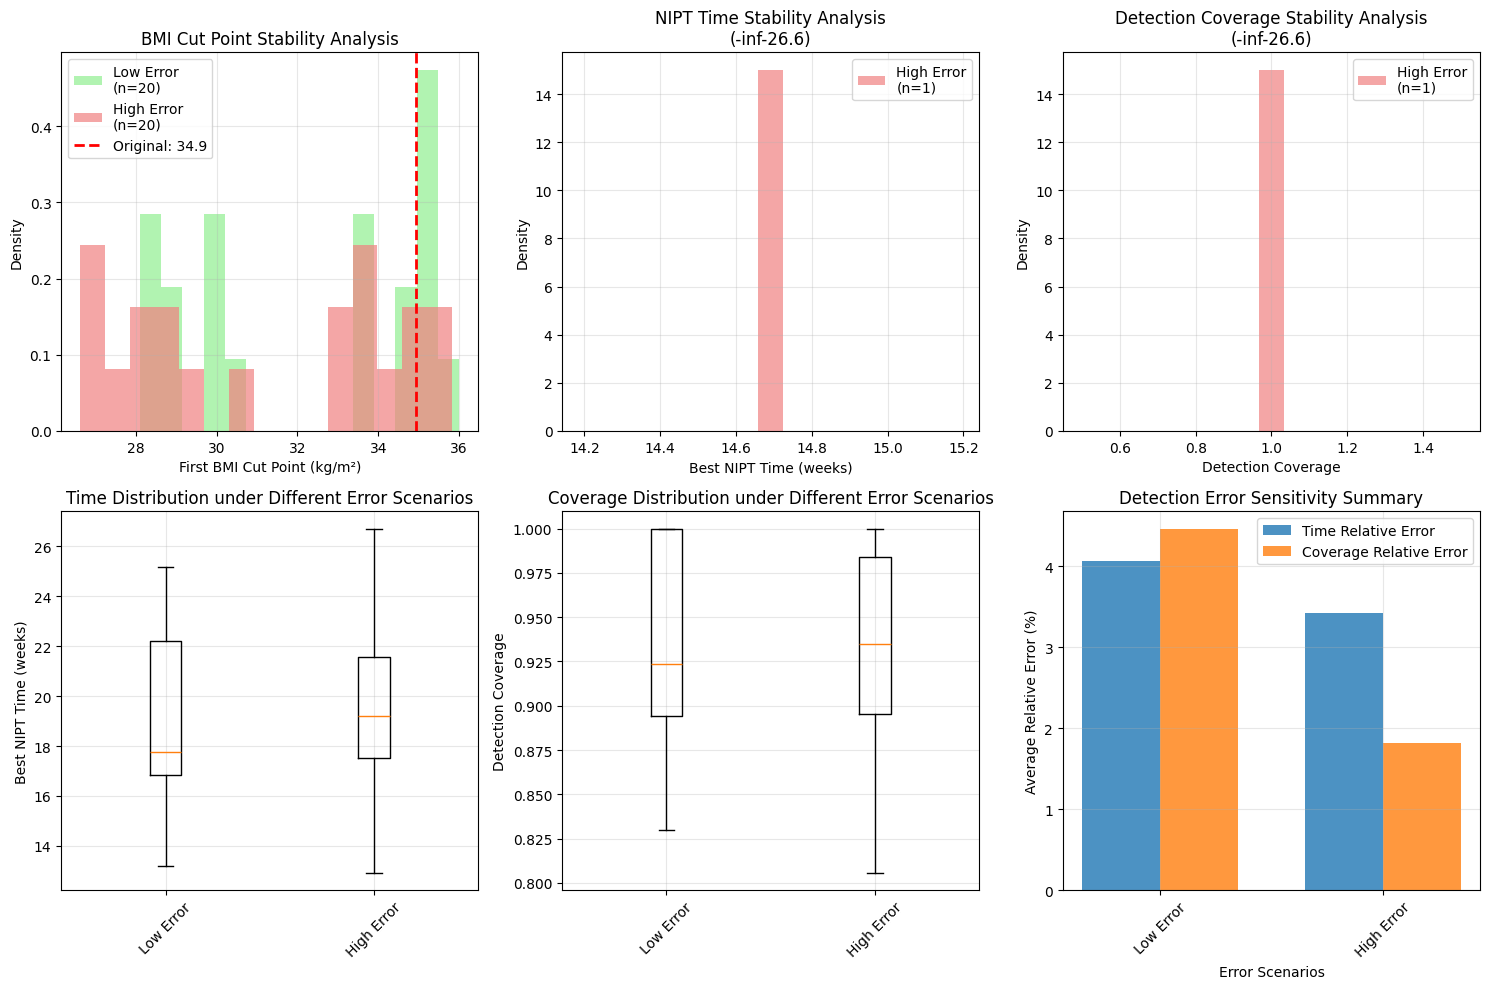

In [10]:
# 可视化误差影响分析
def visualize_error_impact(monte_carlo_results, original_results):
    """可视化检测误差对结果的影响"""
    
    # 准备数据
    scenarios = list(monte_carlo_results.keys())
    scenario_colors = ['lightgreen', 'lightcoral']
    
    # 创建英文标签映射
    scenario_labels = {
        '低误差场景': 'Low Error',
        '高误差场景': 'High Error'
    }
    
    # 1. BMI切点稳定性可视化
    plt.figure(figsize=(15, 10))
    
    # 子图1: BMI切点的分布
    plt.subplot(2, 3, 1)
    for i, (scenario, color) in enumerate(zip(scenarios, scenario_colors)):
        scenario_data = monte_carlo_results[scenario]
        all_first_cuts = []
        
        for cuts in scenario_data['cut_points']:
            if len(cuts) > 0:
                all_first_cuts.append(cuts[0])
        
        if all_first_cuts:
            english_label = scenario_labels.get(scenario, scenario)
            plt.hist(all_first_cuts, bins=15, alpha=0.7, color=color, 
                    label=f'{english_label}\n(n={len(all_first_cuts)})', density=True)
    
    # 添加原始值线
    if len(original_results['cut_points']) > 0:
        plt.axvline(original_results['cut_points'][0], color='red', linestyle='--', 
                   linewidth=2, label=f'Original: {original_results["cut_points"][0]:.1f}')
    
    plt.xlabel('First BMI Cut Point (kg/m²)')
    plt.ylabel('Density')
    plt.title('BMI Cut Point Stability Analysis')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 子图2: 不同误差场景下的时间分布（以第一个组为例）
    plt.subplot(2, 3, 2)
    
    # 找到最常见的组别名称
    all_groups = set()
    for scenario in scenarios:
        for times_dict in monte_carlo_results[scenario]['risk_aware_times']:
            all_groups.update(times_dict.keys())
    
    if all_groups:
        representative_group = sorted(list(all_groups))[0]  # 选择第一个组作为代表
        
        for i, (scenario, color) in enumerate(zip(scenarios, scenario_colors)):
            scenario_data = monte_carlo_results[scenario]
            group_times = []
            
            for times_dict in scenario_data['risk_aware_times']:
                if representative_group in times_dict and np.isfinite(times_dict[representative_group]['objective']):
                    group_times.append(times_dict[representative_group]['t_star'])
            
            if group_times:
                english_label = scenario_labels.get(scenario, scenario)
                plt.hist(group_times, bins=15, alpha=0.7, color=color,
                        label=f'{english_label}\n(n={len(group_times)})', density=True)
        
        # 添加原始值线
        if representative_group in original_results['risk_aware_times']:
            original_time = original_results['risk_aware_times'][representative_group]['t_star']
            if np.isfinite(original_time):
                plt.axvline(original_time, color='red', linestyle='--', 
                           linewidth=2, label=f'Original: {original_time:.1f}w')
        
        plt.xlabel('Best NIPT Time (weeks)')
        plt.ylabel('Density')
        plt.title(f'NIPT Time Stability Analysis\n({representative_group})')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # 子图3: 检测覆盖率分布
    plt.subplot(2, 3, 3)
    
    if all_groups and representative_group:
        for i, (scenario, color) in enumerate(zip(scenarios, scenario_colors)):
            scenario_data = monte_carlo_results[scenario]
            group_coverages = []
            
            for times_dict in scenario_data['risk_aware_times']:
                if representative_group in times_dict and np.isfinite(times_dict[representative_group]['objective']):
                    group_coverages.append(times_dict[representative_group]['coverage'])
            
            if group_coverages:
                english_label = scenario_labels.get(scenario, scenario)
                plt.hist(group_coverages, bins=15, alpha=0.7, color=color,
                        label=f'{english_label}\n(n={len(group_coverages)})', density=True)
        
        # 添加原始值线
        if representative_group in original_results['risk_aware_times']:
            original_coverage = original_results['risk_aware_times'][representative_group]['coverage']
            if np.isfinite(original_coverage):
                plt.axvline(original_coverage, color='red', linestyle='--', 
                           linewidth=2, label=f'Original: {original_coverage:.3f}')
        
        plt.xlabel('Detection Coverage')
        plt.ylabel('Density')
        plt.title(f'Detection Coverage Stability Analysis\n({representative_group})')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # 子图4-6: 误差影响的箱线图
    # 收集所有组别的时间数据用于箱线图
    plt.subplot(2, 3, 4)
    
    time_data_for_boxplot = []
    scenario_labels_for_boxplot = []
    
    for scenario in scenarios:
        scenario_times = []
        for times_dict in monte_carlo_results[scenario]['risk_aware_times']:
            for group, result in times_dict.items():
                if np.isfinite(result['objective']):
                    scenario_times.append(result['t_star'])
        
        if scenario_times:
            time_data_for_boxplot.append(scenario_times)
            english_label = scenario_labels.get(scenario, scenario)
            scenario_labels_for_boxplot.append(english_label)
    
    if time_data_for_boxplot:
        plt.boxplot(time_data_for_boxplot, labels=scenario_labels_for_boxplot)
        plt.ylabel('Best NIPT Time (weeks)')
        plt.title('Time Distribution under Different Error Scenarios')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
    
    # 子图5: 覆盖率箱线图
    plt.subplot(2, 3, 5)
    
    coverage_data_for_boxplot = []
    
    for scenario in scenarios:
        scenario_coverages = []
        for times_dict in monte_carlo_results[scenario]['risk_aware_times']:
            for group, result in times_dict.items():
                if np.isfinite(result['objective']):
                    scenario_coverages.append(result['coverage'])
        
        if scenario_coverages:
            coverage_data_for_boxplot.append(scenario_coverages)
    
    if coverage_data_for_boxplot:
        plt.boxplot(coverage_data_for_boxplot, labels=scenario_labels_for_boxplot)
        plt.ylabel('Detection Coverage')
        plt.title('Coverage Distribution under Different Error Scenarios')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
    
    # 子图6: 误差敏感性总结
    plt.subplot(2, 3, 6)
    
    # 计算相对误差
    relative_errors = {'time': [], 'coverage': []}
    
    for scenario in scenarios:
        scenario_time_errors = []
        scenario_coverage_errors = []
        
        for times_dict in monte_carlo_results[scenario]['risk_aware_times']:
            for group, result in times_dict.items():
                if group in original_results['risk_aware_times'] and np.isfinite(result['objective']):
                    original_time = original_results['risk_aware_times'][group]['t_star']
                    original_coverage = original_results['risk_aware_times'][group]['coverage']
                    
                    if np.isfinite(original_time) and original_time > 0:
                        time_error = abs(result['t_star'] - original_time) / original_time * 100
                        scenario_time_errors.append(time_error)
                    
                    if np.isfinite(original_coverage) and original_coverage > 0:
                        coverage_error = abs(result['coverage'] - original_coverage) / original_coverage * 100
                        scenario_coverage_errors.append(coverage_error)
        
        if scenario_time_errors:
            relative_errors['time'].append(np.mean(scenario_time_errors))
        else:
            relative_errors['time'].append(0)
            
        if scenario_coverage_errors:
            relative_errors['coverage'].append(np.mean(scenario_coverage_errors))
        else:
            relative_errors['coverage'].append(0)
    
    x = np.arange(len(scenarios))
    width = 0.35
    
    plt.bar(x - width/2, relative_errors['time'], width, label='Time Relative Error', alpha=0.8)
    plt.bar(x + width/2, relative_errors['coverage'], width, label='Coverage Relative Error', alpha=0.8)

    plt.xlabel('Error Scenarios')
    plt.ylabel('Average Relative Error (%)')
    plt.title('Detection Error Sensitivity Summary')
    plt.xticks(x, [scenario_labels.get(s, s) for s in scenarios], rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 执行可视化
print(f"\n{'=' * 60}")
print("Generating error impact analysis visualizations...")
print("=" * 60)

visualize_error_impact(monte_carlo_results, original_results)